## Carregando os dados

In [297]:
from google.colab import drive
drive.mount('/content/drive')

# importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

from pandas.plotting import scatter_matrix

# caminho da pasta onde estão os arquivos JSON
pasta = '/content/drive/My Drive/Datasets/content'

# lista todos os arquivos .json dessa pasta
arquivos = [f for f in os.listdir(pasta) if f.endswith('.json')]

dataframes = []

# percorre cada arquivo JSON
for arquivo in arquivos:
    caminho = os.path.join(pasta, arquivo)

    with open(caminho, 'r', encoding='utf-8') as f:
        dados = json.load(f)

    df_temp = pd.DataFrame(dados)
    dataframes.append(df_temp)

# junta tudo em um único DataFrame
df = pd.concat(dataframes, ignore_index=True)

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,usuario_id,curtidas_dia,comentarios_dia,tempo_tela,frequencia_acesso,nivel_vicio
0,1,48,11,baixo,42,nao_viciado
1,2,128,19,baixo,8,nao_viciado
2,3,116,98,alto,10,moderado
3,4,13,68,medio,6,moderado
4,5,36,86,alto,42,viciado


## Pré-processamento: eliminação de atributos irrelevantes

In [298]:
# remove a coluna usuario_id
df = df.drop(columns=['usuario_id'])

# imprime o dataframe
display(df.head(n=10))

,curtidas_dia,comentarios_dia,tempo_tela,frequencia_acesso,nivel_vicio
0,48,11,baixo,42,nao_viciado
1,128,19,baixo,8,nao_viciado
2,116,98,alto,10,moderado
3,13,68,medio,6,moderado
4,36,86,alto,42,viciado
5,1,88,baixo,42,moderado
6,195,76,medio,11,moderado
7,112,68,alto,48,viciado
8,82,13,medio,40,moderado
9,103,65,medio,39,moderado


## Pré-processamento: tratamento de atributos com valores ausentes

In [299]:
# índices das linhas que contém valores NaN
idxRowNan = pd.isnull(df).any(axis=1).to_numpy().nonzero()

# imprime apenas as linhas com valoes ausentes
display(df.iloc[idxRowNan])

,curtidas_dia,comentarios_dia,tempo_tela,frequencia_acesso,nivel_vicio


In [300]:
import pandas as pd
import numpy as np

def limpaInconsistencias(df, categorias_validas=None):
    """
    - Converte valores não numéricos em colunas numéricas para NaN
    - Substitui valores inválidos em colunas categóricas por NaN
    """
    df = df.copy()

    # Define categorias válidas, se fornecidas
    if categorias_validas is None:
        categorias_validas = {}

    # Converte textos em colunas numéricas para NaN
    col_numericas = df.select_dtypes(include=["number"]).columns
    for col in col_numericas:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Substitui valores inválidos em colunas categóricas
    col_categoricas = df.select_dtypes(exclude=["number"]).columns
    for col in col_categoricas:
        if col in categorias_validas:
            df[col] = df[col].where(df[col].isin(categorias_validas[col]), np.nan)

    return df

# imprime apenas as linhas com valoes ausentes
display(df.iloc[idxRowNan])

,curtidas_dia,comentarios_dia,tempo_tela,frequencia_acesso,nivel_vicio


In [301]:
def trataFaltantes(df):
    """
    Preenche valores faltantes com base na classe 'nivel_vicio':
      - Remove linhas com 'nivel_vicio' nulo
      - Numéricas: média da classe
      - Categóricas: moda da classe
    E ao final, exibe linhas que ainda possuem nulos (se houver).
    """
    df = df.copy()

    # Remove linhas onde 'nivel_vicio' está nulo
    df = df.dropna(subset=["nivel_vicio"])

    # Verificação de nulos
    if not df.isnull().values.any():
        print("✔️ Não há valores nulos restantes.")
        return df

    print("⚠️ Valores nulos encontrados! Iniciando preenchimento...\n")

    col_numericas = df.select_dtypes(include=["number"]).columns
    col_categoricas = df.select_dtypes(include=["object"]).columns

    for col in df.columns:
        if df[col].isnull().sum() == 0:
            continue  # Pula se não tiver nulos

        print(f"→ Tratando coluna: {col}")

        # Trata por classe de 'nivel_vicio'
        for classe in df["nivel_vicio"].unique():

            subset = df[df["nivel_vicio"] == classe]
            valores_validos = subset[col].dropna()

            if valores_validos.empty:
                continue

            # Média (numéricas) ou moda (categóricas)
            if col in col_numericas:
                valor_subst = valores_validos.mean()
            else:
                valor_subst = valores_validos.mode()[0]

            df.loc[(df["nivel_vicio"] == classe) & (df[col].isnull()), col] = valor_subst

    print("\n✔️ Preenchimento de faltantes concluído!")

    # Verificação final de nulos
    if df.isnull().values.any():
        print("\n❌ Ainda há dados sem tratamento! Exibindo linhas com nulos:\n")
        print(df[df.isnull().any(axis=1)])
    else:
        print("\n✔️ Todos os dados foram tratados. Nenhum valor nulo presente.")

    return df


In [302]:
# Dicionário com categorias válidas
categorias_validas = {
    "tempo_tela": ["baixo", "medio", "alto"],
    "nivel_vicio": ["viciado", "moderado", "nao_viciado"]
}

# 1: Limpa valores inconsistentes
df_limpo = limpaInconsistencias(df, categorias_validas)

# 2: Trata valores faltantes
df = trataFaltantes(df_limpo)


✔️ Não há valores nulos restantes.


## Pré-processamento: tratamento de dados inconsistentes ou redundantes

In [303]:
df_duplicates = df[ df.duplicated(subset=['curtidas_dia','comentarios_dia','tempo_tela','frequencia_acesso'],keep=False)]

# se houver valores redundantes ou inconsistentes, imprima
if len(df_duplicates)>0:
    print('\nAmostras redundantes ou inconsistentes:')
    display(df_duplicates)
else:
    print('Não existem valores duplicados')

Não existem valores duplicados


In [304]:
def delDuplicatas(df):
   '''
   Para cada grupo de amostras duplicadas, mantém uma e apaga as demais
   '''

   # remove as amostras duplicadas, mantendo apenas a primeira ocorrencia
   df = df.drop_duplicates(keep = 'first')

   return df

df = delDuplicatas(df)

display(df)


,curtidas_dia,comentarios_dia,tempo_tela,frequencia_acesso,nivel_vicio
0,48,11,baixo,42,nao_viciado
1,128,19,baixo,8,nao_viciado
2,116,98,alto,10,moderado
3,13,68,medio,6,moderado
4,36,86,alto,42,viciado
...,...,...,...,...,...
595,116,96,baixo,12,moderado
596,145,25,baixo,15,nao_viciado
597,162,43,alto,40,viciado
598,85,29,medio,38,moderado


In [305]:
# para detectar inconsistências, a rotina abaixo obtém as amostras onde os valores
# dos atributos continuam duplicados. Neste caso, os atributos serão iguais, mas as classes serão distintas
df_duplicates = df[ df.duplicated(subset=['curtidas_dia','comentarios_dia','tempo_tela','frequencia_acesso'],keep=False)]

# se tiver valores inconsistentes, imprime
if len(df_duplicates)>0:
   print('\nAmostras inconsistentes:')
   display(df_duplicates)
else:
   print('Não existem mostras inconsistentes')


Não existem mostras inconsistentes


In [306]:
def delInconsistencias(df):
   '''
   Remove todas as amostras inconsistentes da base de dados
   '''

   df = df.drop_duplicates(subset=['curtidas_dia','comentarios_dia','tempo_tela','frequencia_acesso'], keep = False)
   return df

df = delInconsistencias(df)

# obtém apenas as amostras onde os valores dos atributos estão duplicados
df_duplicates = df[ df.duplicated(subset=['curtidas_dia','comentarios_dia','tempo_tela','frequencia_acesso'],keep=False)]

# se tiver valores redundantes ou inconsistentes, imprime
if len(df_duplicates)>0:
   display(df_duplicates)
else:
   print('Não existem amostras redundantes ou inconsistentes')

Não existem amostras redundantes ou inconsistentes


## Pré-Processamento: codificação de Variáveis Categóricas

In [307]:
# Mapeamento manual
tempo_tela_map = {'baixo': 1, 'medio': 2, 'alto': 3}
df['tempo_tela'] = df['tempo_tela'].map(tempo_tela_map)


In [308]:
# apresenta as principais estatísticas da base de dados
df_detalhes = df.describe()

display(df_detalhes)


,curtidas_dia,comentarios_dia,tempo_tela,frequencia_acesso
count,600.000000,600.00000,600.00000,600.000000
mean,101.410000,52.28500,2.00500,26.840000
std,58.674865,29.59973,0.77199,14.332717
min,0.000000,0.00000,1.00000,1.000000
25%,49.000000,27.00000,1.00000,15.000000
50%,103.000000,51.50000,2.00000,27.000000
75%,151.000000,78.00000,3.00000,40.000000
max,200.000000,100.00000,3.00000,50.000000


## Pré-processamento: normalização dos atributos

In [309]:
def normalizar(X):
   """
   Normaliza os atributos em X

   Esta função retorna uma versao normalizada de X onde o valor da
   média de cada atributo é igual a 0 e desvio padrao é igual a 1. Trata-se de
   um importante passo de pré-processamento quando trabalha-se com
   métodos de aprendizado de máquina.
   """
   m, n = X.shape # m = qtde de objetos e n = qtde de atributos por objeto

   # Inicializa as variáveis de saída
   X_norm = np.random.rand(m,n) # inicializa X_norm com valores aleatórios
   mu = 0 # inicializa a média
   sigma = 1 # inicializa o desvio padrão

   mu = np.mean(X, axis=0)
   sigma = np.std(X, axis=0, ddof=1)

   for i in range(m):
       X_norm[i,:] = (X[i,:] - mu) / sigma

   return X_norm, mu, sigma

# Seleciona apenas colunas numéricas
col_numericas = df.select_dtypes(include=['number']).columns
X = df[col_numericas].values

# Guarda X original apenas com colunas numéricas
col_numericas = df.select_dtypes(include=['number']).columns
X_original = df[col_numericas].values.copy()

# Normaliza com base no X_original
X_norm, mu, sigma = normalizar(X_original)

# Atualiza apenas as colunas numéricas
df[col_numericas] = X_norm

print('\nPrimeira amostra da base antes da normalização: [%2.4f %2.4f].' % (X_original[0, 0], X_original[0, 1]))
print('\nApós a normalização, espera-se que a primeira amostra seja igual a: [-0.5747 0.1804].')
print('\nPrimeira amostra da base após normalização: [%2.4f %2.4f].' % (X_norm[0, 0], X_norm[0, 1]))



Primeira amostra da base antes da normalização: [48.0000 11.0000].

Após a normalização, espera-se que a primeira amostra seja igual a: [-0.5747 0.1804].

Primeira amostra da base após normalização: [-0.9103 -1.3948].


In [310]:
# apresenta as principais estatísticas da base de dados
df_detalhes = df.describe()

display(df_detalhes.round(8))

,curtidas_dia,comentarios_dia,tempo_tela,frequencia_acesso
count,600.000000,600.000000,600.000000,600.000000
mean,0.000000,0.000000,0.000000,0.000000
std,1.000000,1.000000,1.000000,1.000000
min,-1.728338,-1.766401,-1.301831,-1.802868
25%,-0.893227,-0.854231,-1.301831,-0.826082
50%,0.027098,-0.026521,-0.006477,0.011163
75%,0.845166,0.868758,1.288877,0.918179
max,1.680277,1.612008,1.288877,1.615883


## Pré-processamento: detecção de *outliers*

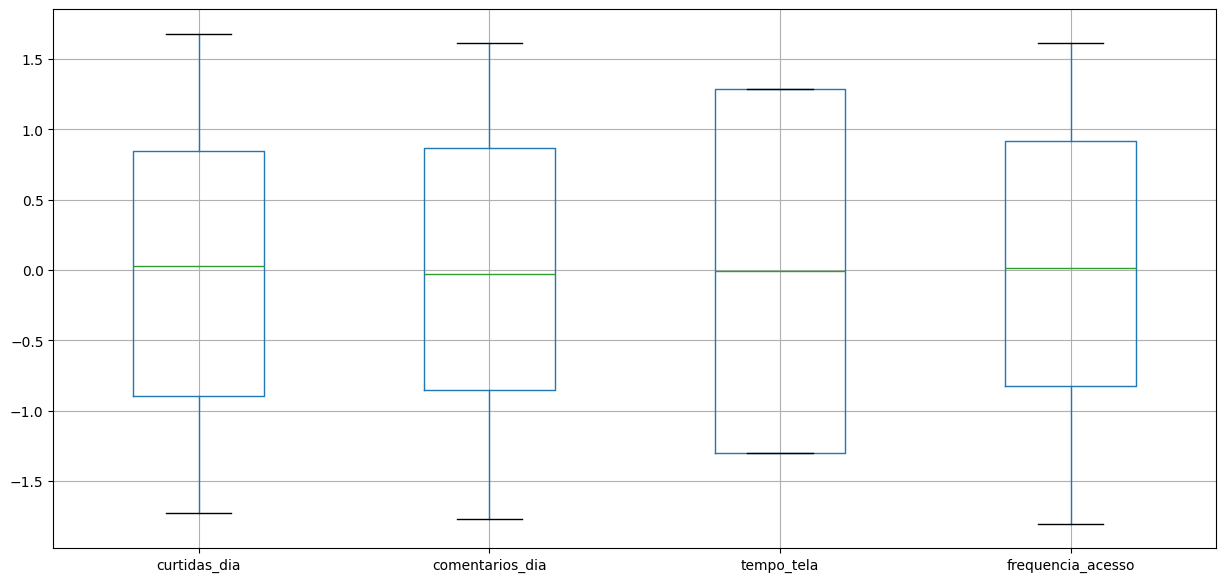

In [311]:
# gera um bloxplot para cada atributo
df.boxplot(figsize=(15,7))
plt.show()


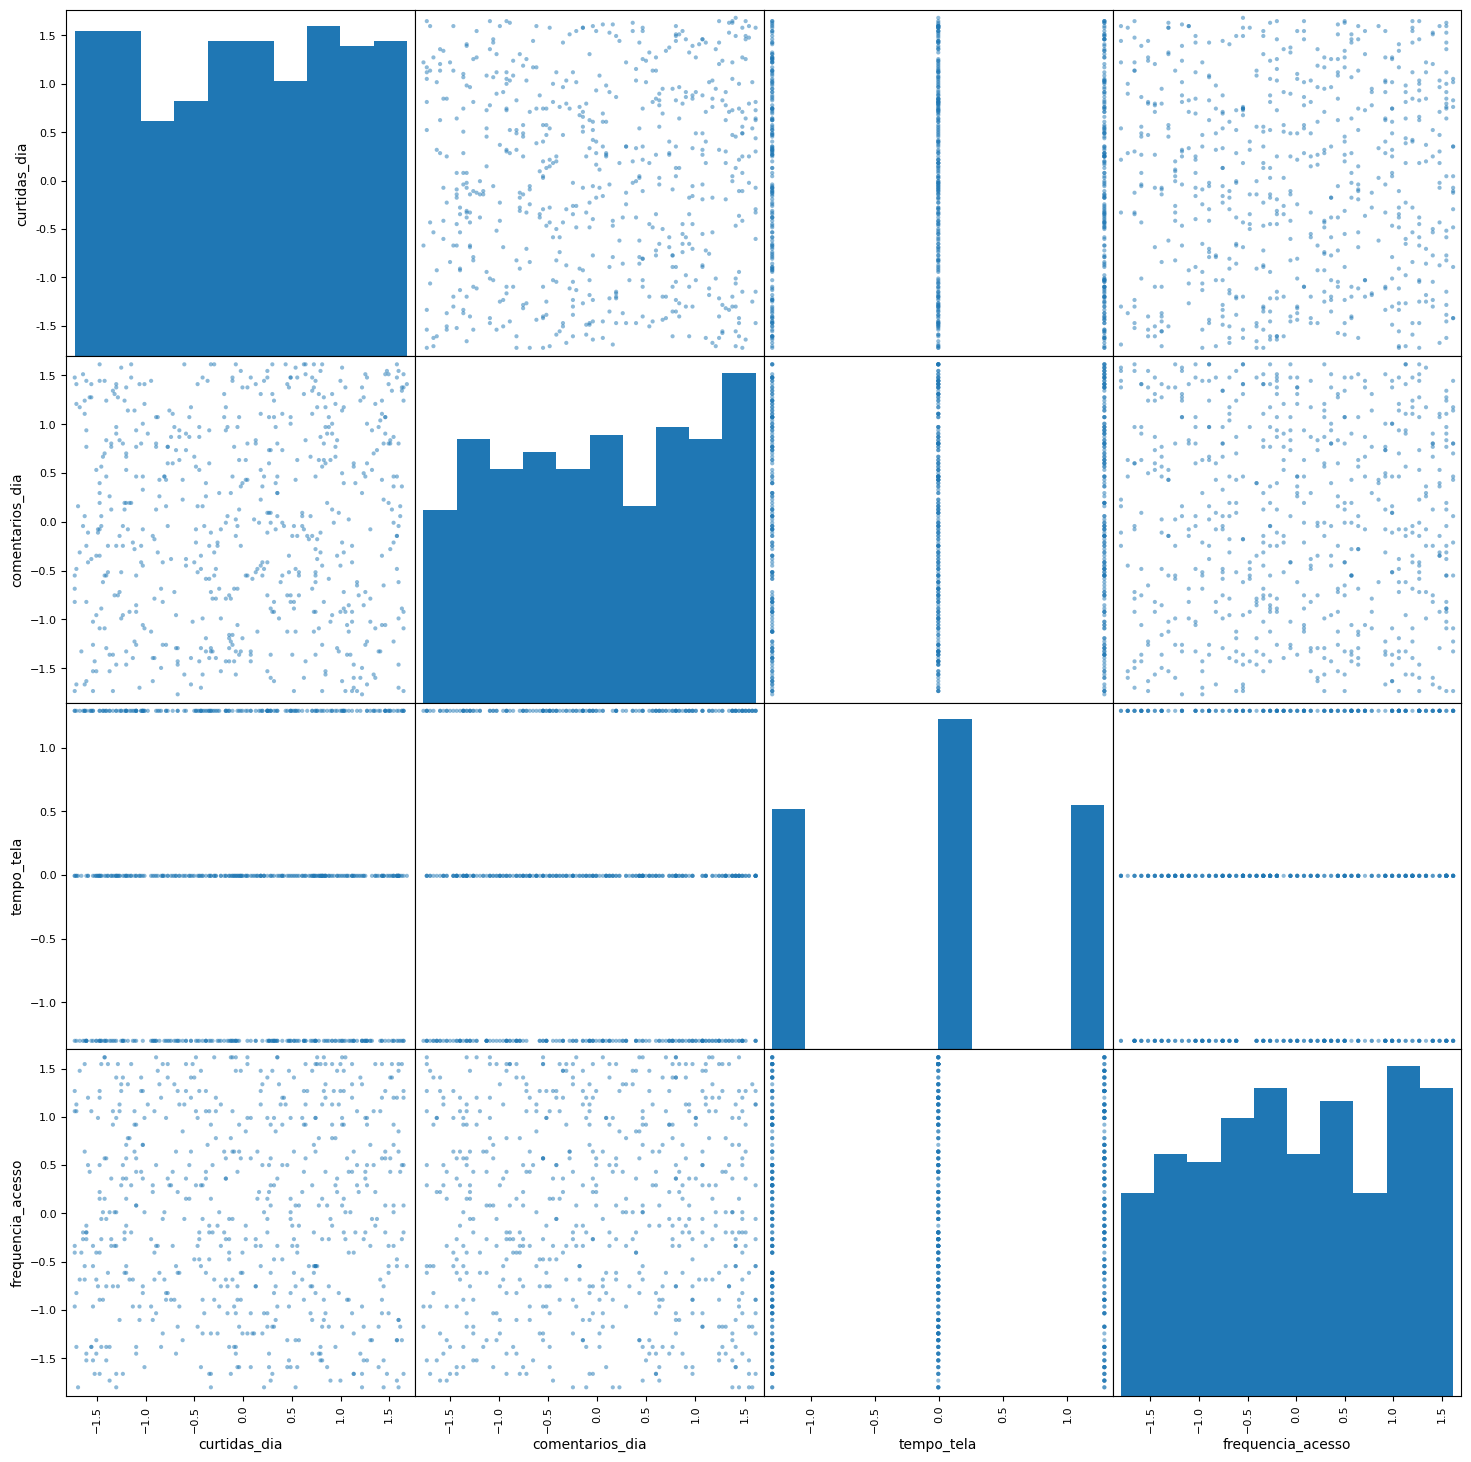

In [312]:
pd.plotting.scatter_matrix(df, figsize=(18,18))
plt.show()


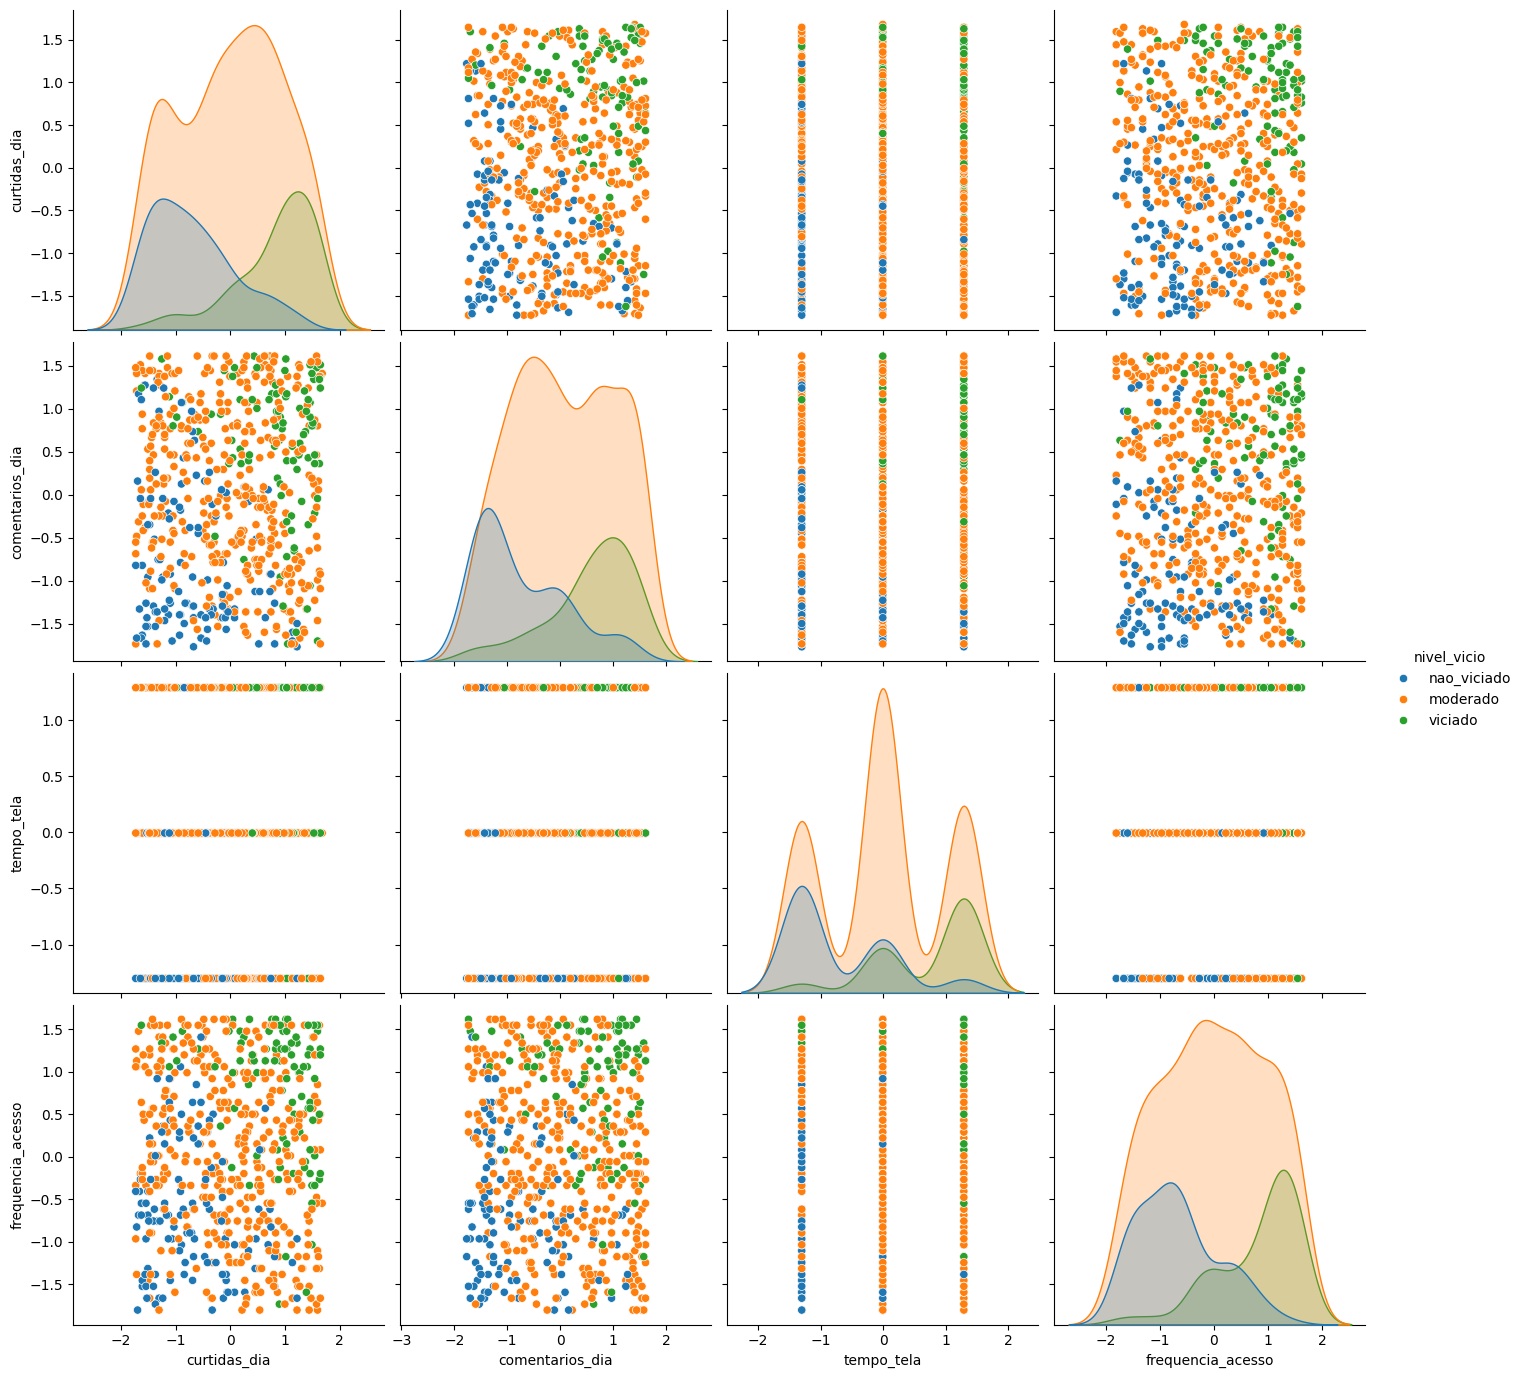

In [313]:
# matriz de gráficos scatter
sns.pairplot(df, hue='nivel_vicio', height=3.5);

# mostra o gráfico usando a função show() da matplotlib
plt.show()


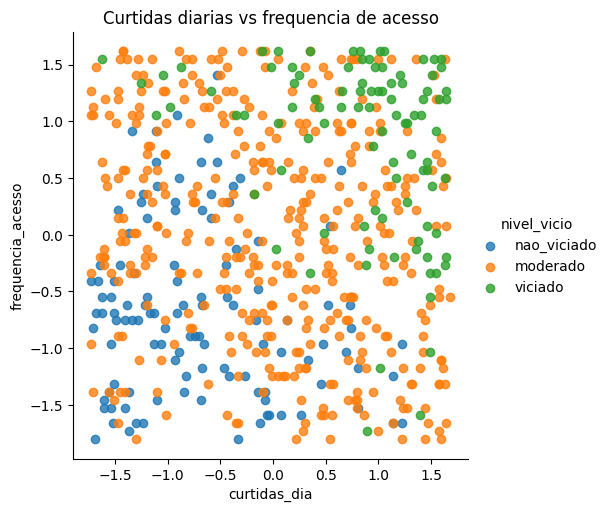

In [314]:
# define o scatter plot
sns.lmplot(x='curtidas_dia', y='frequencia_acesso', data=df,
          fit_reg=False,
          hue='nivel_vicio')

# cria um título para o gráfico
plt.title('Curtidas diarias vs frequencia de acesso')

# mostra o gráfico
plt.show()


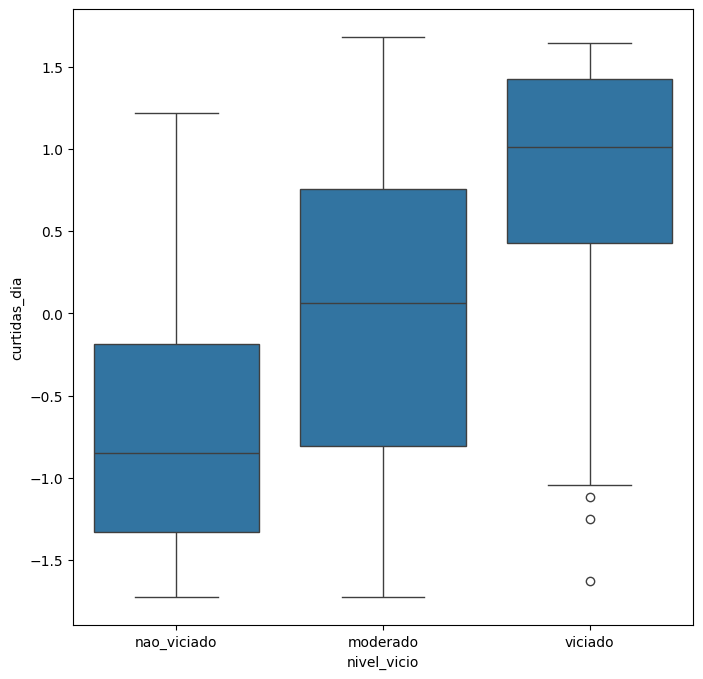

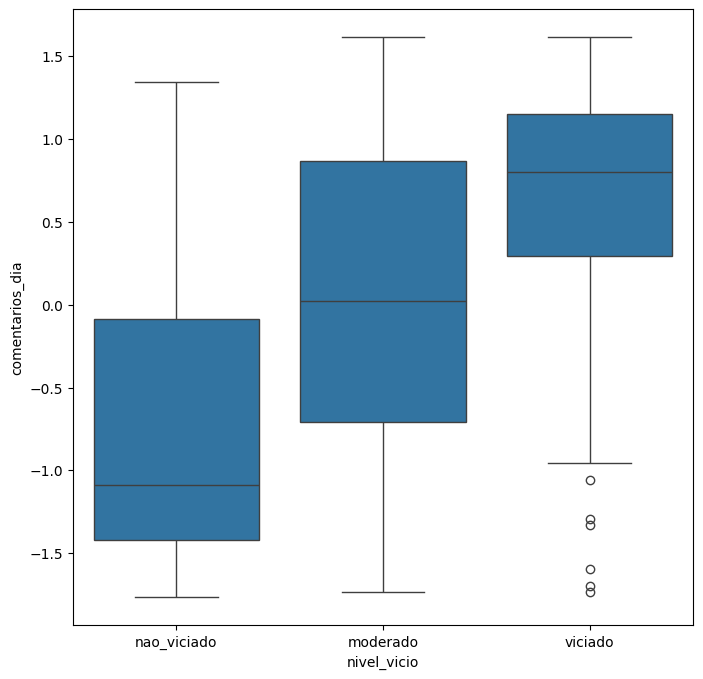

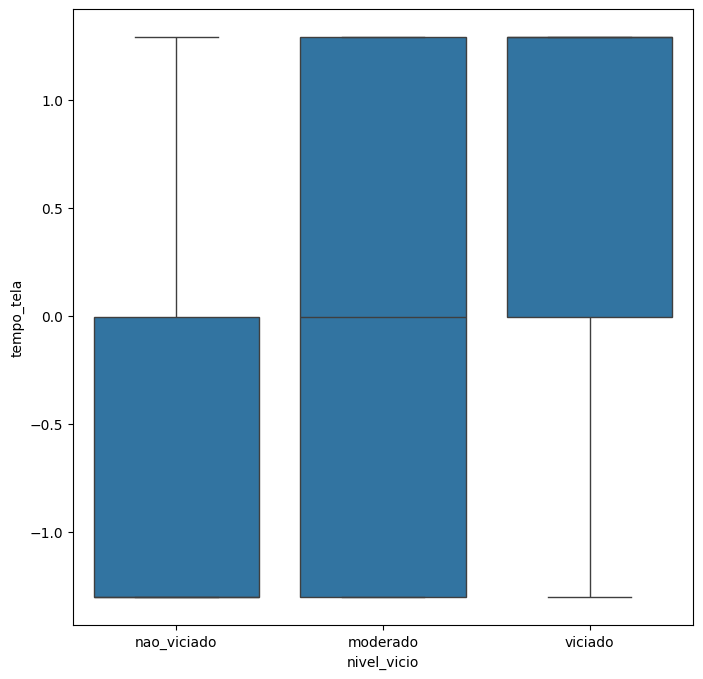

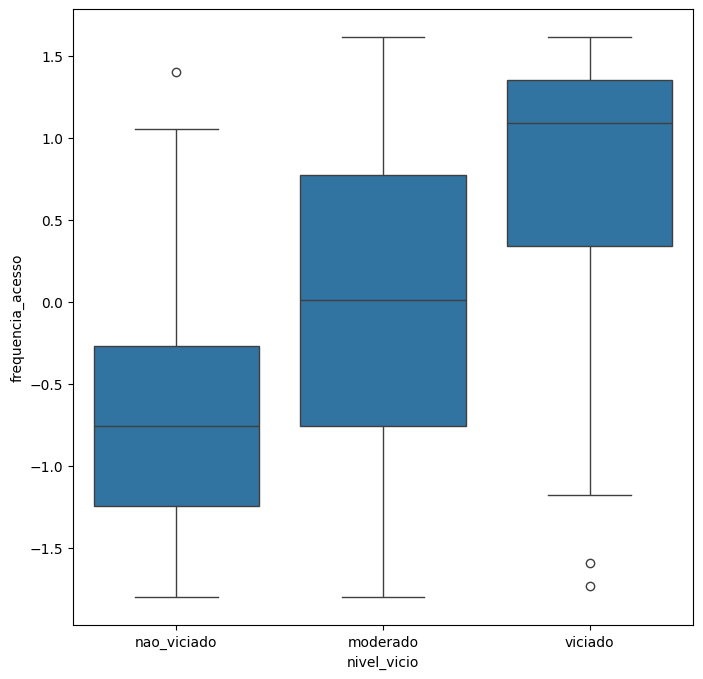

In [315]:
for atributo in df.columns[:-1]:
   # define a dimensão do gráfico
   plt.figure(figsize=(8,8))

   # cria o boxplot
   sns.boxplot(x="nivel_vicio", y=atributo, data=df, whis=1.5)

   # mostra o gráfico
   plt.show()


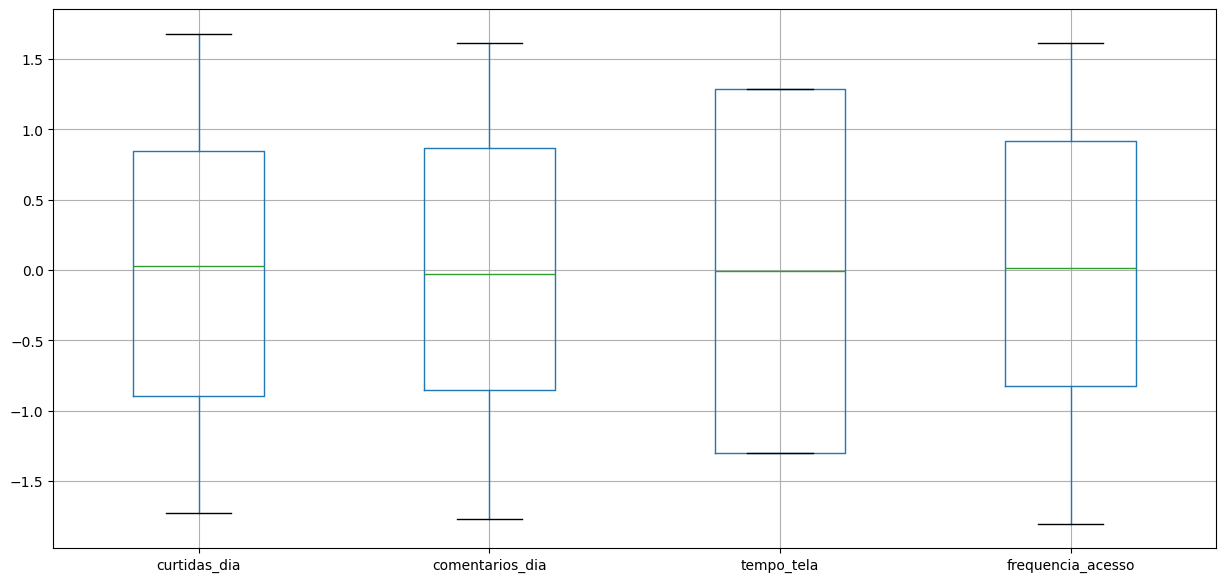

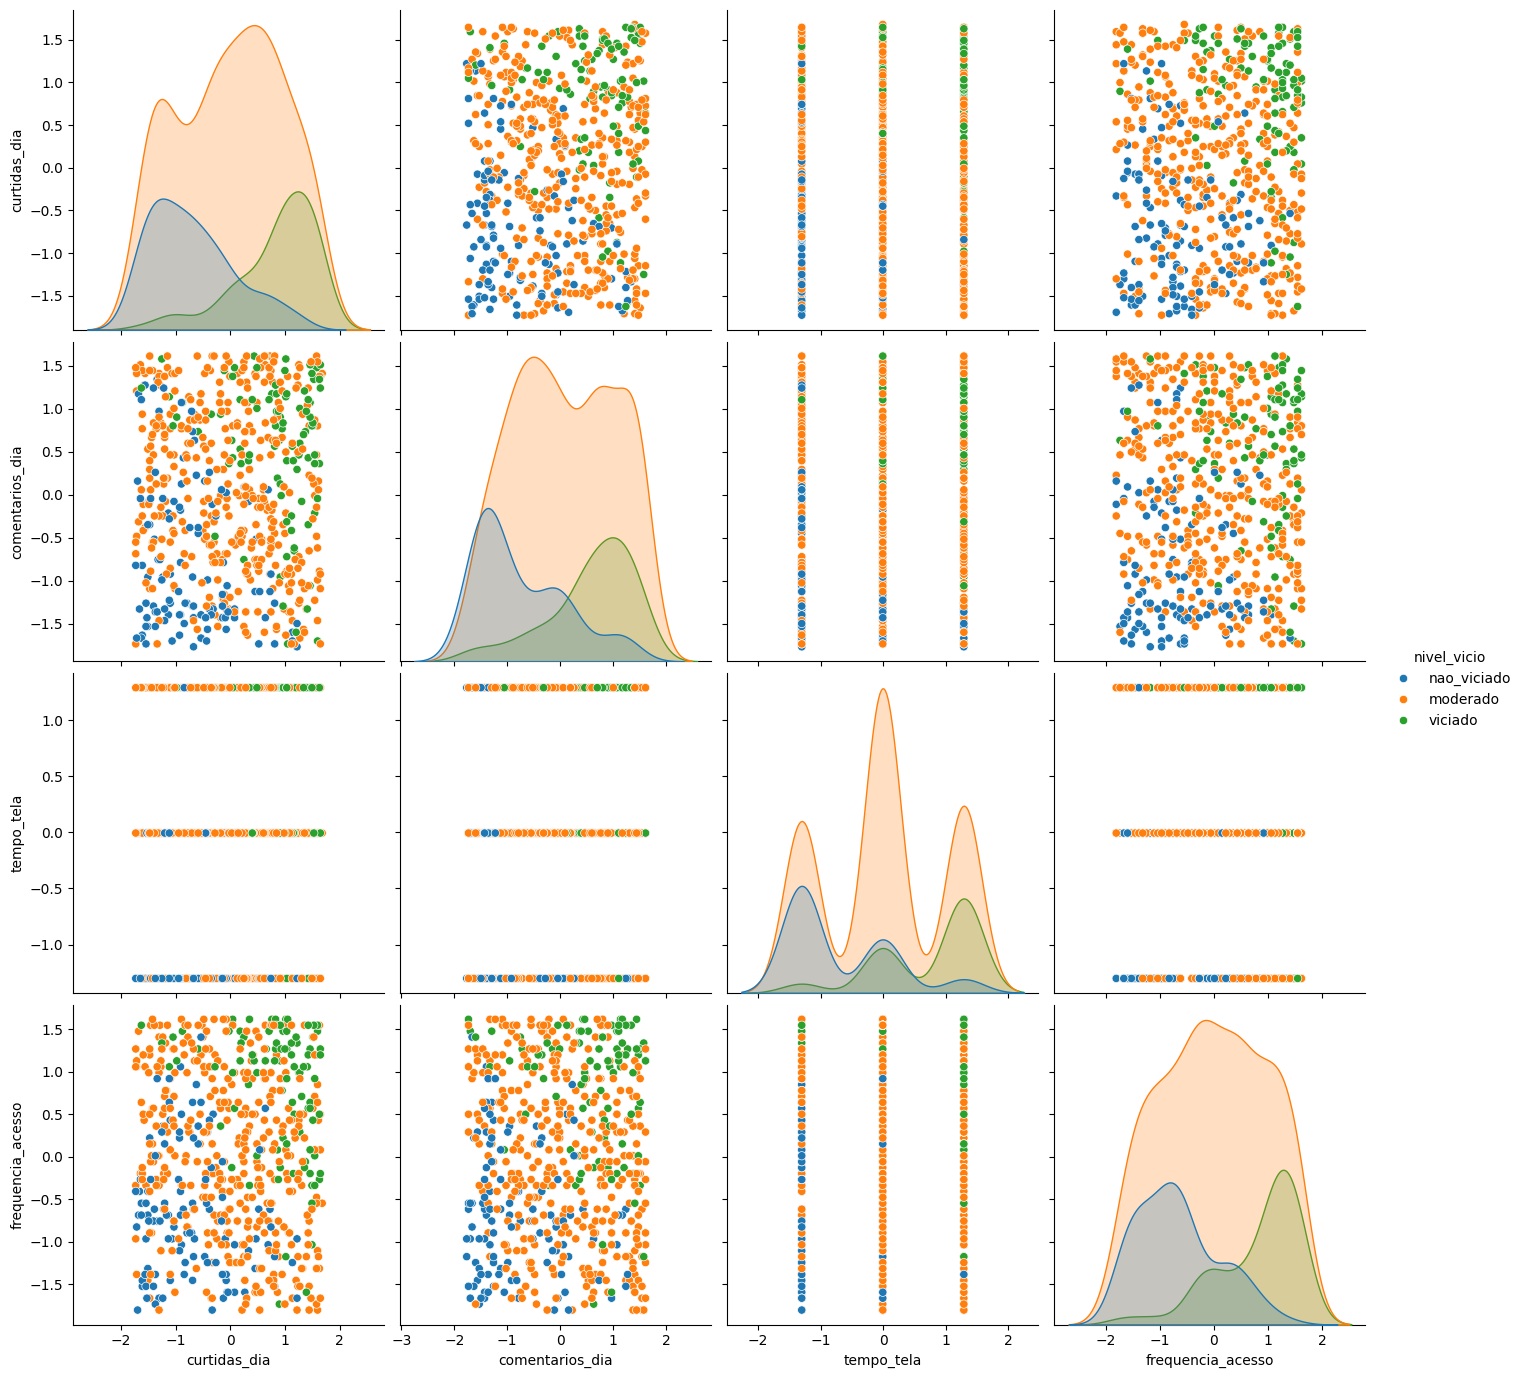

In [316]:
def removeOutliers(df):
    """
    Remove os outliers da base de dados apenas para colunas numéricas
    utilizando a regra do IQR (Interquartile Range).
    """

    df_clean = df.copy()  # Cria uma cópia para evitar alterar o original

    # Seleciona apenas colunas numéricas
    numeric_columns = df.select_dtypes(include=['number']).columns

    for atributo in numeric_columns:
        # Calcula o Q1 e Q3
        q25 = df_clean[atributo].quantile(0.25)
        q75 = df_clean[atributo].quantile(0.75)
        IQR = q75 - q25

        # Define limites inferior e superior
        lower_bound = q25 - 1.5 * IQR
        upper_bound = q75 + 1.5 * IQR

        # Filtra o DataFrame removendo valores fora dos limites
        df_clean = df_clean[(df_clean[atributo] >= lower_bound) & (df_clean[atributo] <= upper_bound)]

    return df_clean

# remove os outliers
df = removeOutliers(df)

# apresenta as principais estatísticas sobre a base de dados
df.boxplot(figsize=(15,7))
plt.show()

# matriz de gráficos scatter
sns.pairplot(df, hue='nivel_vicio', height=3.5)
plt.show()


## Pré-processamento: distribuição das classes

,count
nivel_vicio,
moderado,390
nao_viciado,114
viciado,96


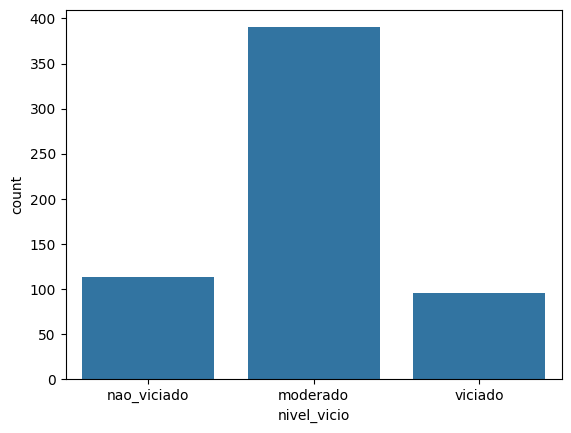

In [317]:
display(df['nivel_vicio'].value_counts())

# cria um gráfico de barras com a frequência de cada classe
sns.countplot(x="nivel_vicio", data=df)

# mostra o gráfico
plt.show()

## Pré-processamento: correlação entre os atributos

In [318]:
# Seleciona apenas colunas numéricas para a matriz X
X = df.select_dtypes(include=['number']).values

# matriz de correlação
correlation = np.corrcoef(X, rowvar=False)

print('\n\nMatriz de correlação: ')
display(correlation)




Matriz de correlação: 


array([[ 1.        ,  0.03985496, -0.03704887,  0.01476425],
       [ 0.03985496,  1.        ,  0.03770905, -0.0231449 ],
       [-0.03704887,  0.03770905,  1.        ,  0.03960311],
       [ 0.01476425, -0.0231449 ,  0.03960311,  1.        ]])

In [319]:
# Seleciona apenas colunas numéricas
df_values = df.select_dtypes(include=['number'])

# matriz de correlação
df_correlation = df_values.corr()

print('\n\nMatriz de correlação: ')
display(df_correlation)




Matriz de correlação: 


,curtidas_dia,comentarios_dia,tempo_tela,frequencia_acesso
curtidas_dia,1.000000,0.039855,-0.037049,0.014764
comentarios_dia,0.039855,1.000000,0.037709,-0.023145
tempo_tela,-0.037049,0.037709,1.000000,0.039603
frequencia_acesso,0.014764,-0.023145,0.039603,1.000000


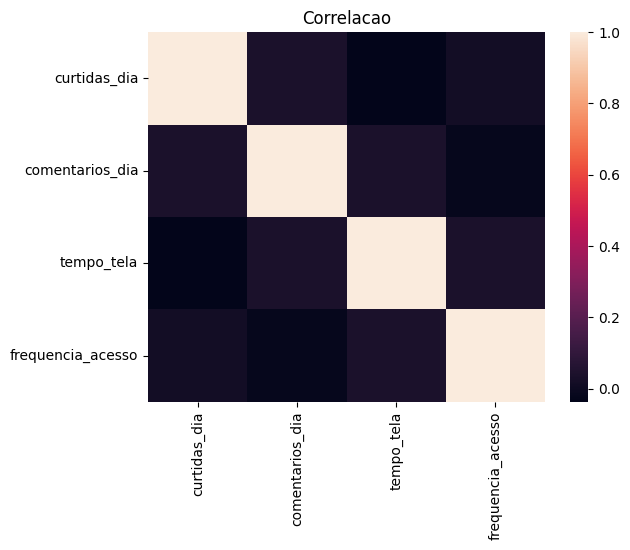

In [320]:
# cria um mapa de cores dos valores da correlação
sns.heatmap(df_correlation,
        xticklabels=df_correlation.columns,
        yticklabels=df_correlation.columns)

plt.title('Correlacao')
plt.show()

## Pré-Processamento: codificação de Variáveis Categóricas/²
##### transformando os valores categoricos da classe em numeros para facilitar o treinamento dos algoritmos na etapa de extração de padrões.

In [255]:
# Mapeamento
# nivel_vicio_map = {'nao_viciado': 0, 'moderado': 1, 'viciado': 2,'muito_viciado':3}
# df['nivel_vicio'] = df['nivel_vicio'].map(nivel_vicio_map)

In [321]:
# Caminho de destino no Drive
caminho_destino = '/content/drive/My Drive/Datasets/content/processed/dados_processados.csv'

# Salvar o DataFrame final como CSV
df.to_csv(caminho_destino, index=False)

print(f"Arquivo salvo com sucesso em: {caminho_destino}")


Arquivo salvo com sucesso em: /content/drive/My Drive/Datasets/content/processed/dados_processados.csv
